In [ ]:
# from imblearn.over_sampling import SMOTE 
import matplotlib.pyplot as plt
import numpy as np
import random
import sys

# TODO: 
#   - make the automatic process of loading the whole dataset and parse the labels
#           from actual data so that the program could be used with unknown labels.
#   - add data normalization.

data = (['2','4'], ['Data/breast+cancer+wisconsin+original/breast-cancer-wisconsin.data', 'Data/breast_dataset.data'], False, 1)
# data = (['Iris-versicolor', 'Iris-virginica'], ['Data/iris/iris.data', 'Data/iris_dataset.data'], True, 0)
labels = data[0] # labels to be used for the classification
unprocessed_file = data[1][0] # file to load the unprocessed data
processed_file = data[1][1] # file to save the processed data, or to load the processed data for the model
augment = data[2] # indicator (boolean) whether to augment the data or not
relevant_data_beggining_indicatior = data[3] # the first relevant element in the row. 0 is the first elemnt. Must be Integer.
split_coff = 0.2 # split coefficient for the training and testing data (0.2 means 80% training and 20% testing)


In [ ]:
# deletes rows with question marks "?" and the Id column
# replaces class names with 0 and 1

def process_file(input_file, output_file, class_labels, relevant_data_beggining_indicatior):
    with open(input_file, 'r') as infile:
        lines = infile.readlines()

    with open(output_file, 'w') as outfile:
        for line in lines:
            if '?' not in line:
                new_line = line.strip().split(',')
                if new_line[-1] == class_labels[0]:
                    new_line[-1] = '0'
                elif new_line[-1] == class_labels[1]:
                    new_line[-1] = '1'
                else:
                    continue
                new_line = ','.join(new_line[relevant_data_beggining_indicatior:])
                outfile.write(new_line + '\n')

process_file(unprocessed_file, processed_file, labels, relevant_data_beggining_indicatior)


In [ ]:
## reading data from a file and augment if set to true
def get_dataset(file_path, augment):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    augmented_lines = []
    if augment:
        while len(augmented_lines) < 300: # get 300 augmented data instances
            augmented_data = []
            for l in lines:
                line = np.array(l.strip().split(','), dtype=float)
                label = line[-1]
                data_point = line[:-1]
                noise = np.random.normal(0, 0.2, data_point.shape)
                new_data = data_point + noise
                new_data = str(new_data.tolist()) + ',' + str(label) + '\n'
                new_data = new_data.replace('[', '').replace(']', '').replace(' ', '')
                augmented_data.append(new_data)
            augmented_lines += augmented_data

    combined_lines = lines + augmented_lines
    random.shuffle(combined_lines)
    dataset = []
    labels = []
    for line in combined_lines:
        line = line.strip().split(',')
        dataset.append(list(line[:-1]))
        labels.append(line[-1])

    dataset = np.array(dataset).astype(float)
    labels = np.array(labels).astype(float)
    # strategy = 'all'
    # if data[0].__contains__('2'):
    #     strategy = 'minority'
    # smote = SMOTE(sampling_strategy=strategy)
    # dataset, labels = smote.fit_resample(dataset, labels)

    # dataset = dataset.tolist()
    # labels = labels.tolist()
    return dataset, labels, lines, augmented_lines

# a, b, c, d = get_dataset(file_path=processed_file, augment=augment)

In [5]:
def plot_augmented_data(lines, augmented_lines):
    if(augment == False):
        print('Nėra augmentuotų duomenų :(')
        return
    lines_array = np.array([list(map(float, line.strip().split(','))) for line in lines])
    augmented_lines_array = np.array([list(map(float, line.strip().split(','))) for line in augmented_lines])

    plt.scatter(lines_array[:, 0], lines_array[:, 1], color='blue', label='Originalūs duomenys', alpha=0.5)

    plt.scatter(augmented_lines_array[:, 0], augmented_lines_array[:, 1], color='red', label='Augmenteuoti duomenys', alpha=0.35)

    plt.title('Originalaus ir augmentuoto duomenų paketo pasiskirstymas')
    plt.legend()
    plt.show()
a, b, c, d = get_dataset(file_path=processed_file, augment=augment)
plot_augmented_data(c, d)

Nėra augmentuotų duomenų :(


In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -300, 300))) # Clipped for numerical stability

def get_accuracy(predictions, labels):
    predicted_labels = (predictions >= 0.5).astype(int)
    return np.mean(predicted_labels == labels)

def get_precision(predictions, labels):
    predicted_labels = (predictions >= 0.5).astype(int)
    true_positives = np.sum((predicted_labels == 1) & (labels == 1))
    predicted_positives = np.sum(predicted_labels == 1)
    return true_positives / predicted_positives if predicted_positives != 0 else 0

def get_recall(predictions, labels):
    predicted_labels = (predictions >= 0.5).astype(int)
    true_positives = np.sum((predicted_labels == 1) & (labels == 1))
    actual_positives = np.sum(labels == 1)
    return true_positives / actual_positives if actual_positives != 0 else 0

def get_f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# calculates the accuracy of trained model using testing + training data (DUE TO TRAINING DATA USAGE - NOT RELIABLE)
def check_weights(dataset, weights, labels):
    predictions = sigmoid(np.dot(dataset, weights))
    predicted_labels = (predictions >= 0.5).astype(int)
    correct_rate = np.mean(predicted_labels == labels)
    return correct_rate

In [ ]:
class Neuron():
    def __init__(self, dataset, labels, split_coff, weights, boundaries = 1):
        self.weights = weights
        # self.weights = np.random.uniform(-boundaries, boundaries, len(dataset[0]))
        split_index = int(len(dataset) * split_coff)
        
        self.test_dataset = dataset[split_index:]
        self.test_labels = labels[split_index:]
        self.labels = labels[:-split_index]
        self.dataset = dataset[:-split_index]

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -300, 300))) # Clipped for numerical stability

    def train(self, epochs, learning_rate):
        totalError = float('inf')
        row_number = len(self.dataset) 
        errorTimeLine = []
        accuracyTimeLine = []
        error_rate = 0.001
        epoch = 0

        while totalError > error_rate and epoch < epochs:
            if epoch % (epochs // 4) == 0:
                print(f"Epocha: {epoch}")
            totalError = 0
            
            predictions = self.sigmoid(np.dot(self.dataset, self.weights))
            gradients = np.dot((predictions - self.labels) * predictions * (1 - predictions), self.dataset)
            self.weights -= learning_rate * gradients / row_number ## can be used with optimizers like momentum or Adam
            
            totalError = np.mean((self.labels - predictions) ** 2)
            accuracy = get_accuracy(predictions, self.labels)

            # added for experimenting purposes
            # exits the training if the model performs well in the first 2% of epochs
            if epoch < epochs*0.02 and (totalError < 0.5 or accuracy > 0.5) and not augment:
                print(f"Early stopping at epoch {epoch}")
                sys.exit()
                return self.weights, errorTimeLine, accuracyTimeLine

            errorTimeLine.append(totalError)
            accuracyTimeLine.append(accuracy)

            epoch += 1
        return self.weights, errorTimeLine, accuracyTimeLine
    
    def test(self):
        predictions = self.sigmoid(np.dot(self.test_dataset, self.weights))
        mse = round(np.mean((predictions - self.test_labels) ** 2), 5)
        accuracy = round(get_accuracy(predictions, self.test_labels), 5)
        percision = round(get_precision(predictions, self.test_labels), 5)
        recall = round(get_recall(predictions, self.test_labels), 5)
        f1_score = round(get_f1_score(percision, recall), 5)
        return mse, accuracy, percision, recall, f1_score

In [ ]:
# MAIN

# Main is cludured due to the testing of different learning rates

import time
from IPython.display import clear_output

tests_properties = [3, 10] # [number of different learning rates, boundaries]
boundaries = tests_properties[1]


# while True:
#     times = 0
dataset, labels, data, augmented_data = get_dataset(processed_file, augment)
dataset = np.vstack((dataset.T, np.ones(len(dataset)))).T
random_weights = np.random.uniform(-boundaries, boundaries, len(dataset[0]))

weights_answer = []
errorTimeLine = []
accuracyTimeline = []
learning_rate = list(0.1 / pow(2,i)for i in range(tests_properties[0]))
learning_rate = list(reversed(learning_rate))
for i in range(tests_properties[0]):
    # dataset, labels, data, augmented_data = get_dataset(processed_file, augment)
    random_weights_copy = random_weights.copy()
    neuron = Neuron(dataset, labels, split_coff, random_weights_copy, boundaries)
    w, e, a = neuron.train(epochs=500000, learning_rate=learning_rate[i])

    weights_answer.append(w)
    errorTimeLine.append(e)
    accuracyTimeline.append(a)

    mse, accuracy, percision, recall, f1_score = neuron.test()
    custom_accuracy = check_weights(dataset, w, labels)
    print(f"({i}) Tikslumas: {custom_accuracy * 100:.2f}%")
    print(f"({i}) MSE: {mse:.2%}, Accuracy: {accuracy:.2%}, Precision: {percision:.2%}, Recall: {recall:.2%}, F1 Score: {f1_score:.2%}", '\n')
    # print('\n', random_weights)
    # if accuracy < 0.90 and custom_accuracy < 0.9:
    #     times = 0
    #     break
    # else:
    #     times += 1
    #     if times == 3:
    #         sys.exit()
    #     elif i == 2:
    #         times = 0
    # time.sleep(1)
    # clear_output(wait=True)
weights_answer = np.stack(weights_answer)
errorTimeLine = np.stack(errorTimeLine)
accuracyTimeline = np.stack(accuracyTimeline)

plot_augmented_data(data, augmented_data)

Epocha: 0
Epocha: 125000
Epocha: 250000
Epocha: 375000
(0) Tikslumas: 89.90%
(0) MSE: 10.82%, Accuracy: 89.03%, Precision: 90.91%, Recall: 75.27%, F1 Score: 82.35% 

Epocha: 0
Epocha: 125000
Epocha: 250000
Epocha: 375000
(1) Tikslumas: 97.07%
(1) MSE: 2.99%, Accuracy: 96.89%, Precision: 94.24%, Recall: 96.77%, F1 Score: 95.49% 

Epocha: 0
Epocha: 125000
Epocha: 250000
Epocha: 375000
(2) Tikslumas: 97.80%
(2) MSE: 2.18%, Accuracy: 97.62%, Precision: 95.29%, Recall: 97.85%, F1 Score: 96.55% 

Nėra augmentuotų duomenų :(


In [ ]:
print(weights_answer)

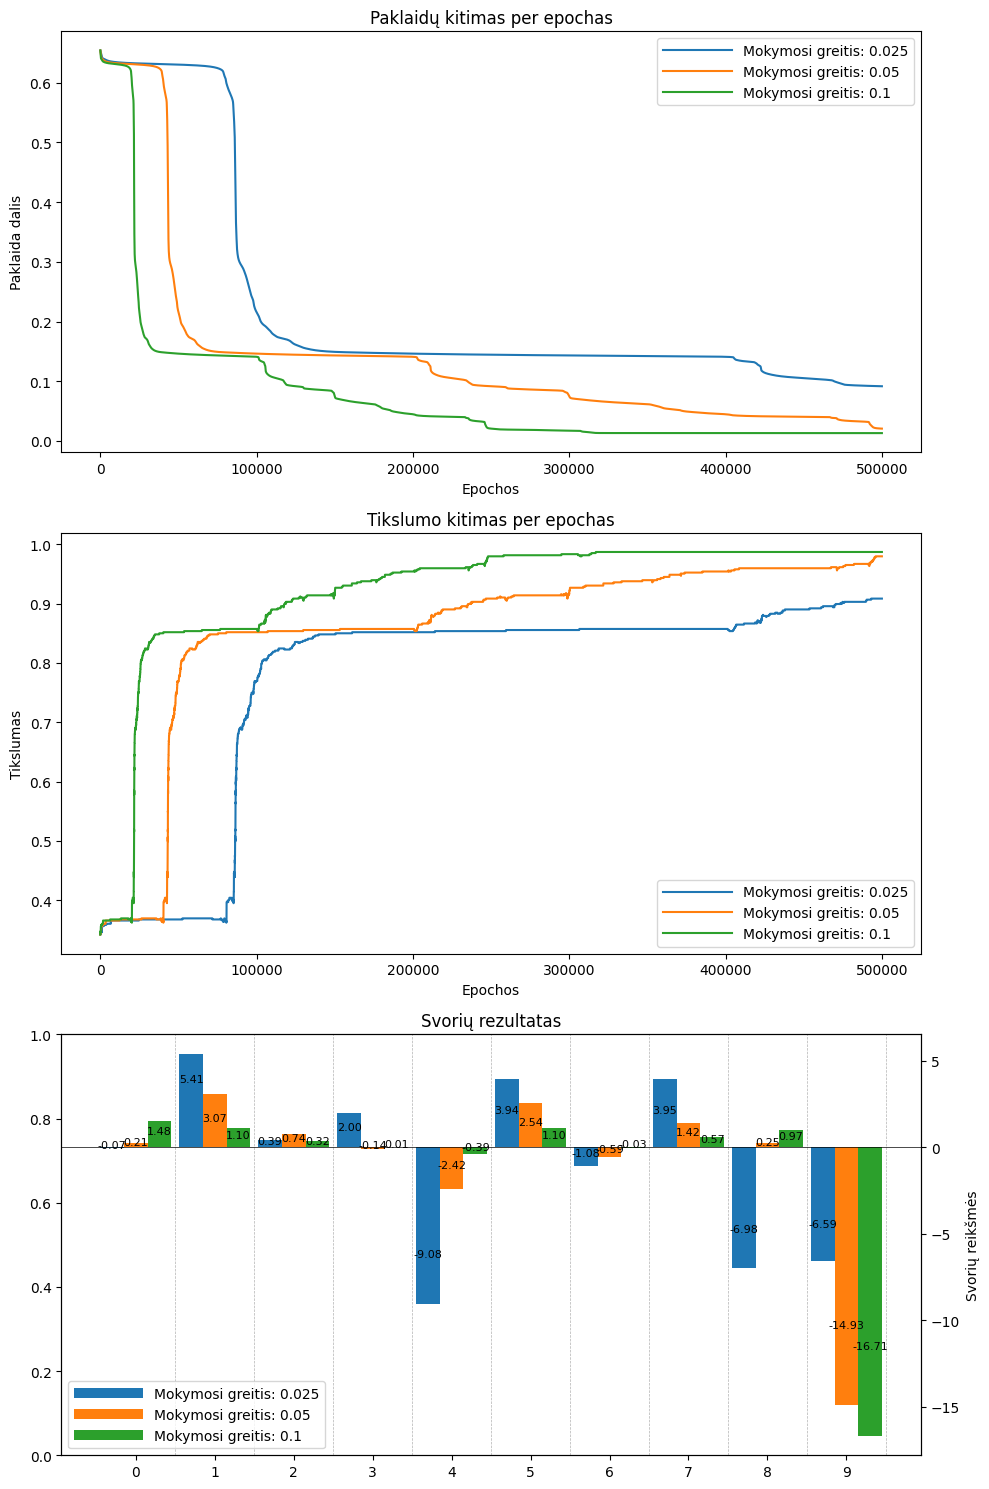

In [13]:
def print_graphs(weights, errorTimeLine, accuracyTimeline, learning_rate):
    fig, axs = plt.subplots(3, figsize=(10, 15))
    length_row = len(weights)
    length_comlumn = len(weights[0])
    legend_names = [f'Mokymosi greitis: {learning_rate[i]}' for i in range(length_row)]
    x = np.arange(length_comlumn)

    for i in range(length_row):
        axs[0].plot(range(len(errorTimeLine[i])), errorTimeLine[i])
        axs[1].plot(range(len(accuracyTimeline[i])), accuracyTimeline[i])

    axs2 = axs[2].twinx()
    width = 0.3
    axs2.bar(x - width, weights[0], width)
    axs2.bar(x, weights[1], width)
    axs2.bar(x + width, weights[2], width)
    for i in range(length_row):
        for idx, value in enumerate(weights[i]):
            p_amp = 0.7 if abs(value) > 5 else 0.5
            shift = -width if i == 0 else (width if i == 2 else 0)
            axs2.text(x = idx + shift, y = value*p_amp, s=f'{value:.2f}', ha='center', fontsize=8)

    axs[0].set_xlabel('Epochos')
    axs[0].set_ylabel('Paklaida dalis')
    axs[0].set_title('Paklaidų kitimas per epochas')
    axs[0].legend(legend_names, loc='best', handlelength=5)
    
    axs[1].set_xlabel('Epochos')
    axs[1].set_ylabel('Tikslumas')
    axs[1].set_title('Tikslumo kitimas per epochas')
    axs[1].legend(legend_names, loc='best', handlelength=5)
    
    axs2.set_ylabel('Svorių reikšmės')
    axs2.set_title('Svorių rezultatas')
    axs2.legend(legend_names, loc='best', handlelength=5)
    axs2.axhline(0, color='black', linewidth=0.5)
    for i in range(length_comlumn):
        axs2.axvline(i + 0.5, color='black', linestyle='--', linewidth=0.5, alpha=0.3)
    axs2.yaxis.set_label_position("right")
    axs2.set_xticks(range(length_comlumn))
    axs2.set_xticklabels(range(length_comlumn))
    
    plt.tight_layout()
    plt.show()

print_graphs(weights_answer, errorTimeLine, accuracyTimeline, learning_rate)
